# Best paintings of all time classification tasks

In [2]:
! pip install opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.8/54.8 MB 9.5 MB/s eta 0:00:00:00:0100:01


In [4]:
import numpy as np
import pandas as pd 
import cv2
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil
import random
from glob import glob

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score


## Data exploration and analysis

In [8]:
np.random.seed(7)
general = pd.read_csv('artists.csv')
artists = general[['name','paintings']]
artists = artists.sort_values(by=['paintings'],ascending=False)

In [5]:
def plot_artist_images(artist_name: str, image_directory: str, img_dim=(128, 128), grid_size=(5, 5)):
    print(artist_name)
    all_files = os.listdir(image_directory)
    normalized_artist_name = artist_name.replace(' ', '_').lower()
    image_files = [file for file in all_files if normalized_artist_name in file.lower() and file.lower().endswith(('.jpg'))]
    
    print(f"Total number of images: {len(image_files)}")
    
    plt.rcParams['figure.figsize'] = (15, 15)
    plt.subplots_adjust(wspace=0, hspace=0)
    
    for index, image_path in enumerate(image_files[:3]):
        img_path = os.path.join(image_directory, image_path)
        img = cv2.imread(img_path)
        img = cv2.resize(img, img_dim)
        plt.subplot(grid_size[0], grid_size[1], index + 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
    plt.show()

Paul Cezanne
Total number of images: 47


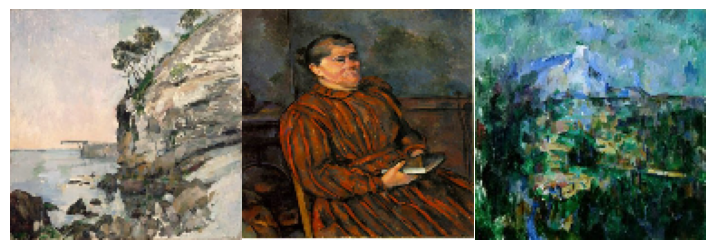

In [6]:
images_directory= './paintings'
images = os.listdir('./paintings')
artist_name = 'Paul Cezanne'
plot_artist_images(artist_name, images_directory)

Andy Warhol
Total number of images: 181


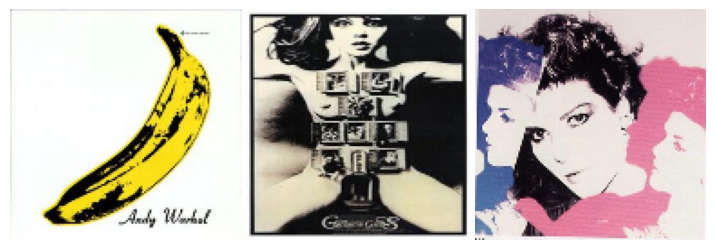

In [7]:
plot_artist_images('Andy Warhol', images_directory)

In [8]:
plt.figure(figsize=(5,5))
nationalities = sns.countplot(y='nationality',data=general)
nationalities.set_title('Artists National Distribution')
plt.show()

NameError: name 'general' is not defined

<Figure size 500x500 with 0 Axes>

In [10]:
plt.figure(figsize=(5,5))
nationalities = sns.countplot(y='genre' ,data=general, order = general['genre'].value_counts().index)
nationalities.set_title('Artistic Movements Distribution')
plt.show()

NameError: name 'general' is not defined

<Figure size 500x500 with 0 Axes>

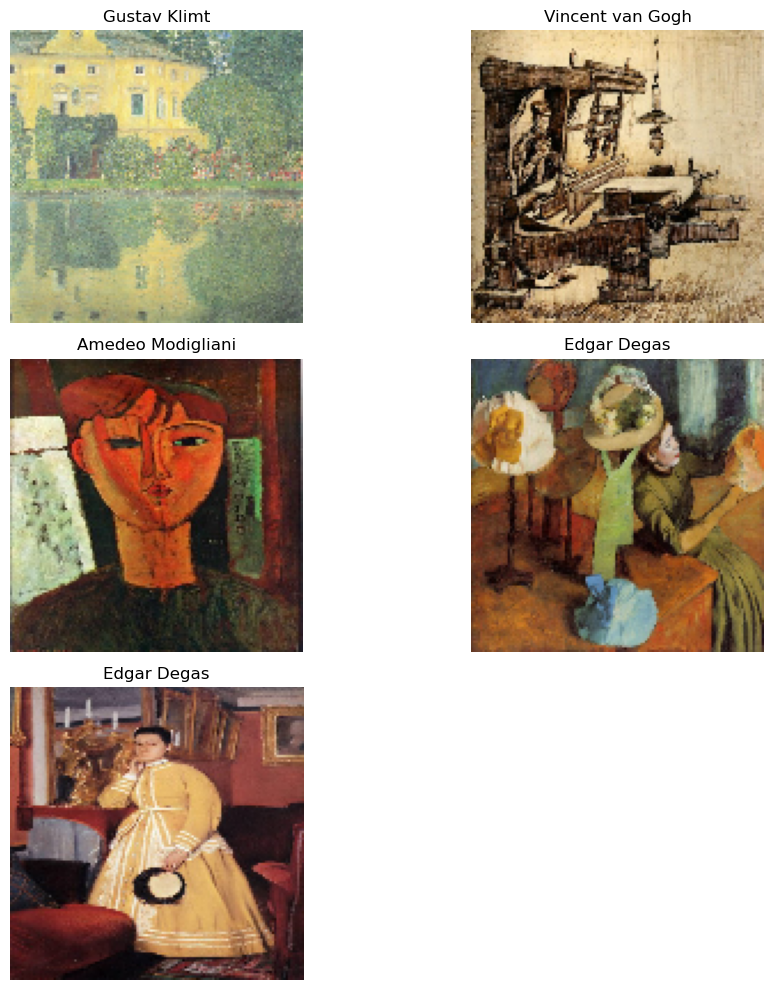

In [11]:
num_paintings = 5
all_files = os.listdir(images_directory)
image_files = [f for f in all_files if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]

plt.figure(figsize=(10, 10)) 

for i, filename in enumerate(image_files[:num_paintings]):
    artist_name = ' '.join(filename.split('_')[:-1]).replace('_', ' ')
    img_path = os.path.join(images_directory, filename)
    img = cv2.imread(img_path)
    img = cv2.resize(img, (128, 128))
        
    ax = plt.subplot((num_paintings + 1) // 2, 2, i + 1)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.set_title(artist_name)
    ax.axis('off')

plt.tight_layout()
plt.show()



In [12]:
import unicodedata
def normalize_name(name):
    return unicodedata.normalize('NFKD', name).encode('ASCII', 'ignore').decode('ASCII')

To load the other informations regarding the painters and preprocessing the data: 

In [13]:
def load_artist_info(csv_path):
    artist_df = pd.read_csv(csv_path)
    artist_info = {}
    for index, row in artist_df.iterrows():
        # We normalize to handle special characters and spaces 
        artist_key = normalize_name(row['name']).replace(' ', '_')
        artist_info[artist_key] = {
            'name': row['name'],
            'genre': row['genre'],
            'nationality': row['nationality']
        }
    return artist_info

We perform `HOG feature extraction` on the images to get the features of the images so that we will be able to effectively capture the shape and appearance of local objects within an the paintings.

In [138]:
def extract_hog_features(image_path):
    img = cv2.imread(image_path)
    if img is None:
        return None
    img = cv2.resize(img, (128, 128))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    hog = cv2.HOGDescriptor()
    h = hog.compute(gray)
    return h.flatten()

We prepare the dataset to be used in a multilabel classification task.

In [140]:
def prepare_dataset(image_directory, artist_info):
    features = []
    labels = []
    
    for filename in os.listdir(image_directory):
        if filename.endswith(".jpg"):
            # We extract the painter's name from the filename
            artist_id_parts = filename.rsplit('_', 1)[0]  #To remove the info we do not need 
            artist_key = normalize_name(artist_id_parts)  #We normalize the name to handle special characters and spaces
            
            if artist_key in artist_info:
                img_path = os.path.join(image_directory, filename)
                img_features = extract_hog_features(img_path) #We extract the HOG features@
                if img_features is not None:
                    features.append(img_features)
                    labels.append([artist_info[artist_key]['name'], artist_info[artist_key]['genre'], artist_info[artist_key]['nationality']])
            else:
                print(f"Missing artist info for ID: {artist_key}, Filename: {filename}")
    return features, labels



Here we encode the labels using LabelEncoder. We will use the encoded labels to train the model;

In [141]:
X, y = load_and_preprocess_data('./paintings',  './artists.csv')


mlb_name = MultiLabelBinarizer()
mlb_genre = MultiLabelBinarizer()
mlb_nationality = MultiLabelBinarizer()

y_encoded = np.concatenate([
    mlb_name.fit_transform(y[:, 0].reshape(-1, 1)),
    mlb_genre.fit_transform(y[:, 1].reshape(-1, 1)),
    mlb_nationality.fit_transform(y[:, 2].reshape(-1, 1))
], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)


In [155]:
# Batch generator for incremental training
def batch_generator(data, batch_size=100):
    """Yield consecutive batches of size batch_size from the data."""
    for i in range(0, len(data), batch_size):
        yield data[i:i + batch_size]

# Incremental training with partial_fit
def train_model_in_batches(X_train, y_train, batch_size=100):
    base_estimator = SGDClassifier(loss='hinge', penalty='l2', alpha=0.0001, random_state=42)
    model = MultiOutputClassifier(base_estimator)
    classes = [np.unique(y_train[:, i]) for i in range(y_train.shape[1])]  # Ensure all classes are known at the start
    data = list(zip(X_train, y_train))  # Prepare the data once

    for batch_index, batch in enumerate(batch_generator(data, batch_size)):
        X_batch, y_batch = zip(*batch)
        X_batch = np.array(X_batch)
        y_batch = np.array(y_batch)

        if batch_index == 0:
            model.partial_fit(X_batch, y_batch, classes=classes)
        else:
            model.partial_fit(X_batch, y_batch)
    
    return model

model = train_model_in_batches(X_train, y_train, batch_size=100)



##### Multi-label CNN model

In [ ]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)
datagen.fit(X_train)

def create_multilabel_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='sigmoid')
    ])
    return model

In [ ]:
input_shape = (128, 128, 3)
num_classes = y_encoded.shape[1]

model = create_multilabel_cnn_model(input_shape, num_classes)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

epochs = 30
batch_size = 32
history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),validation_data=(X_test, y_test),epochs=epochs,callbacks=[early_stopping])

Model evaluation and prediction

In [ ]:
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

#We split the predictions into the three label categories
y_test_name, y_test_genre, y_test_nationality = np.split(y_test, [mlb_name.classes_.size, mlb_name.classes_.size + mlb_genre.classes_.size], axis=1)
y_pred_name, y_pred_genre, y_pred_nationality = np.split(y_pred_binary, [mlb_name.classes_.size, mlb_name.classes_.size + mlb_genre.classes_.size], axis=1)

print("Classification report for artist name:")
print(classification_report(y_test_name, y_pred_name, target_names=mlb_name.classes_))
print("Classification report for genre:")
print(classification_report(y_test_genre, y_pred_genre, target_names=mlb_genre.classes_))
print("Classification report for nationality:")
print(classification_report(y_test_nationality, y_pred_nationality, target_names=mlb_nationality.classes_))

# Overall model accuracy
overall_accuracy = (accuracy_score(y_test_name, y_pred_name) +
                    accuracy_score(y_test_genre, y_pred_genre) +
                    accuracy_score(y_test_nationality, y_pred_nationality)) / 3
print(f"Overall model accuracy: {overall_accuracy}")

In [22]:
import os
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Function to load and preprocess the dataset
def load_and_preprocess_data(image_directory, csv_path):
    # Load artist information from CSV
    artist_df = pd.read_csv(csv_path)
    artist_info = {}
    for index, row in artist_df.iterrows():
        artist_key = normalize_name(row['name']).replace(' ', '_')
        artist_info[artist_key] = {
            'name': row['name'],
            'genre': row['genre'],
            'nationality': row['nationality']
        }
    # Prepare the dataset
    features = []
    labels = []
    for filename in os.listdir(image_directory):
        if filename.endswith(".jpg"):
            artist_id_parts = filename.rsplit('_', 1)[0]  # Remove the last part (usually a number and extension)
            artist_key = normalize_name(artist_id_parts)  # Normalize the artist key

            
            if artist_key in artist_info:
                img_path = os.path.join(image_directory, filename)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, (128, 128))
                    features.append(img)
                    labels.append([artist_info[artist_key]['name'], artist_info[artist_key]['genre'], artist_info[artist_key]['nationality']])
            else:
                print(f"Missing artist info for ID: {artist_key}, Filename: {filename}")
    
    features = np.array(features)
    labels = np.array(labels)
    return features, labels

# Load and preprocess the data
image_directory = './paintings'
csv_path = './artists.csv'
X, y = load_and_preprocess_data(image_directory, csv_path)

# Encode the labels using MultiLabelBinarizer
mlb_name = MultiLabelBinarizer()
mlb_genre = MultiLabelBinarizer()
mlb_nationality = MultiLabelBinarizer()

y_encoded = np.concatenate([
    mlb_name.fit_transform(y[:, 0].reshape(-1, 1)),
    mlb_genre.fit_transform(y[:, 1].reshape(-1, 1)),
    mlb_nationality.fit_transform(y[:, 2].reshape(-1, 1))
], axis=1)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)
datagen.fit(X_train)

# Define the multi-label CNN model
def create_multilabel_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='sigmoid')
    ])
    return model

# Create and compile the model
input_shape = (128, 128, 3)
num_classes = y_encoded.shape[1]

model = create_multilabel_cnn_model(input_shape, num_classes)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
epochs = 30
batch_size = 32
history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                    validation_data=(X_test, y_test),
                    epochs=epochs,
                    callbacks=[early_stopping])

# Evaluate the model
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

# Split the predictions for each label category
y_test_name, y_test_genre, y_test_nationality = np.split(y_test, [mlb_name.classes_.size, mlb_name.classes_.size + mlb_genre.classes_.size], axis=1)
y_pred_name, y_pred_genre, y_pred_nationality = np.split(y_pred_binary, [mlb_name.classes_.size, mlb_name.classes_.size + mlb_genre.classes_.size], axis=1)

# Evaluate and print classification reports for each label category
print("Classification report for artist name:")
print(classification_report(y_test_name, y_pred_name, target_names=mlb_name.classes_))

print("Classification report for genre:")
print(classification_report(y_test_genre, y_pred_genre, target_names=mlb_genre.classes_))

print("Classification report for nationality:")
print(classification_report(y_test_nationality, y_pred_nationality, target_names=mlb_nationality.classes_))

# Calculate overall accuracy
overall_accuracy = (accuracy_score(y_test_name, y_pred_name) +
                    accuracy_score(y_test_genre, y_pred_genre) +
                    accuracy_score(y_test_nationality, y_pred_nationality)) / 3
print(f"Overall model accuracy: {overall_accuracy}")


Epoch 1/30
209/209 [==============================] - 72s 341ms/step - loss: 0.8782 - accuracy: 0.0218 - val_loss: 0.6832 - val_accuracy: 0.0000e+00
Epoch 2/30
209/209 [==============================] - 72s 343ms/step - loss: 0.6783 - accuracy: 1.4961e-04 - val_loss: 0.6735 - val_accuracy: 0.0000e+00
Epoch 3/30
209/209 [==============================] - 72s 345ms/step - loss: 0.6691 - accuracy: 0.0000e+00 - val_loss: 0.6643 - val_accuracy: 0.0000e+00
Epoch 4/30
209/209 [==============================] - 71s 341ms/step - loss: 0.6597 - accuracy: 0.0000e+00 - val_loss: 0.6550 - val_accuracy: 0.0000e+00
Epoch 5/30
209/209 [==============================] - 76s 365ms/step - loss: 0.6505 - accuracy: 1.4961e-04 - val_loss: 0.6459 - val_accuracy: 0.0000e+00
Epoch 6/30
209/209 [==============================] - 73s 347ms/step - loss: 0.6414 - accuracy: 0.0000e+00 - val_loss: 0.6369 - val_accuracy: 0.0000e+00
Epoch 7/30
209/209 [==============================] - 71s 339ms/step - loss: 0.6325 - 

/Users/dianasolfonseca/tensorflow-test/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dianasolfonseca/tensorflow-test/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/dianasolfonseca/tensorflow-test/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg

In [28]:
y_pred = model.predict(X_test)
print(y_pred.shape )

53/53 [==============================] - 5s 100ms/step
(1671, 98)


In [40]:
y_pred_binary = (y_pred > 0.5).astype(int)


# Split the predictions for each label category
split_points = [mlb_name.classes_.size, mlb_name.classes_.size + mlb_genre.classes_.size]
y_test_name, y_test_genre, y_test_nationality = np.split(y_test, split_points, axis=1)
y_pred_name, y_pred_genre, y_pred_nationality = np.split(y_pred_binary, split_points, axis=1)

y_test_name = mlb_name.inverse_transform(y_test_name)
y_pred_name = mlb_name.inverse_transform(y_pred_name)

print(y_test_name[:5])
print(y_pred_name[:5])

[('Albrecht Dürer',), ('Francisco Goya',), ('Pierre-Auguste Renoir',), ('Gustave Courbet',), ('Francisco Goya',)]
[(), (), (), (), ()]


In [33]:
# Load and preprocess a single image
def load_and_preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (128, 128))
    img = img.astype('float32') / 255.0
    return img

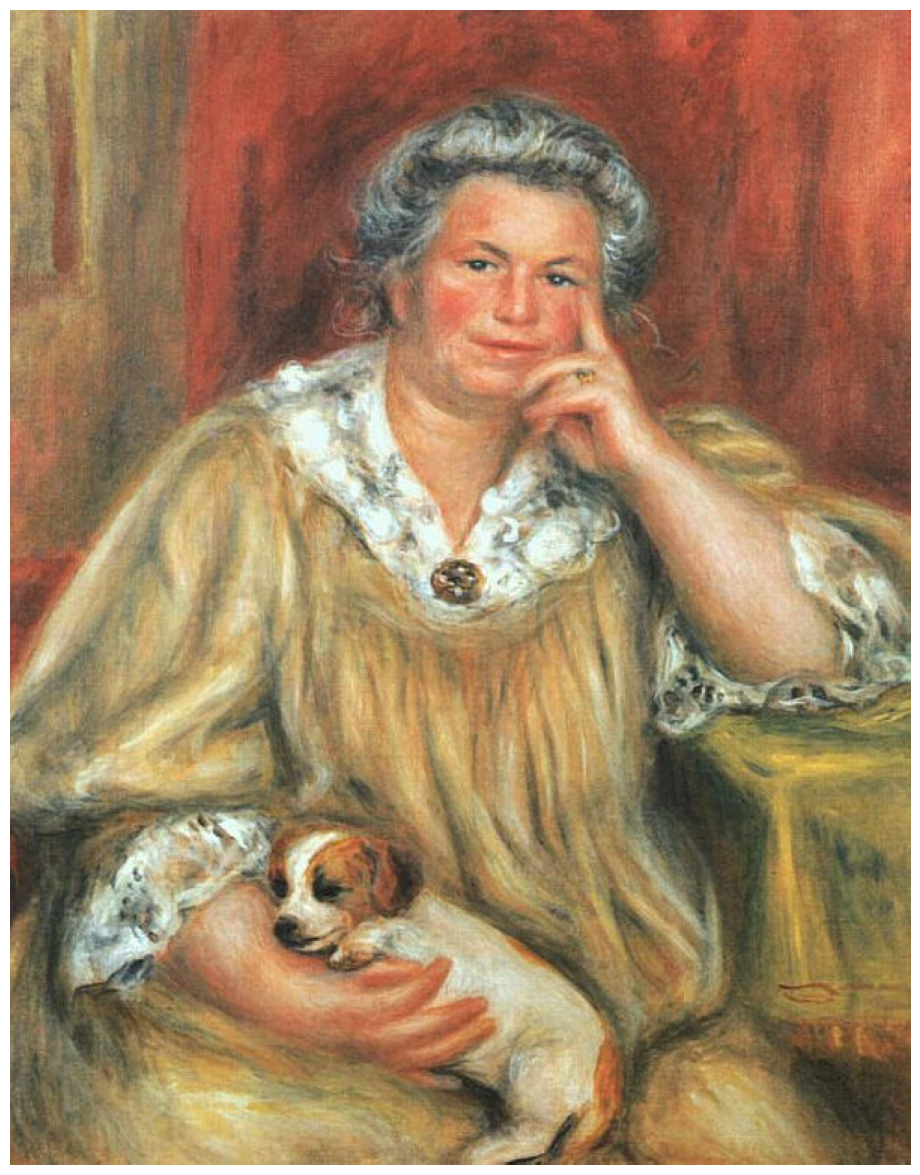

1/1 [==============================] - 0s 20ms/step
[()]
Predicted artist name(s): [()]
Predicted genre(s): [()]
Predicted nationality(s): [()]


In [35]:
index = 21  # Change this index to test different images
image_path = os.path.join(image_directory, os.listdir(image_directory)[index])

# Display the chosen image
plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# Make predictions for the chosen image
def predict_single_image(model, image_path, mlb_name, mlb_genre, mlb_nationality):
    img = load_and_preprocess_image(image_path)
    img = np.expand_dims(img, axis=0)  # Add batch dimension

    prediction = model.predict(img)
    prediction_binary = (prediction > 0.5).astype(int)

    pred_name, pred_genre, pred_nationality = np.split(prediction_binary, split_points, axis=1)

    name_labels = mlb_name.inverse_transform(pred_name)
    print(name_labels)
    genre_labels = mlb_genre.inverse_transform(pred_genre)
    nationality_labels = mlb_nationality.inverse_transform(pred_nationality)

    return name_labels, genre_labels, nationality_labels

name_labels, genre_labels, nationality_labels = predict_single_image(model, image_path, mlb_name, mlb_genre, mlb_nationality)

# Print the predictions
print("Predicted artist name(s):", name_labels)
print("Predicted genre(s):", genre_labels)
print("Predicted nationality(s):", nationality_labels)

In [23]:
from sklearn.metrics import classification_report, accuracy_score

In [21]:
def predict_new_image(image_path, model, label_encoder):
    # Extract features
    features = extract_hog_features(image_path)
    if features is None:
        return "Could not load or process image."
    
    # Predict using the trained model
    features = np.array([features])  # Convert to 2D array for prediction
    predicted_class_index = model.predict(features)[0]
    predicted_artist = label_encoder.inverse_transform([predicted_class_index])[0]
    return predicted_artist

image_path = './paintings/Andy_Warhol_1.jpg'
predicted_artist = predict_new_image(image_path, model, le)
print("Predicted Artist:", predicted_artist)


Predicted Artist: Andy


In [ ]:
def load_artist_info(csv_path):
    artist_df = pd.read_csv(csv_path)
    artist_info = {}
    for index, row in artist_df.iterrows():
        # We normalize to handle special characters and spaces 
        artist_key = normalize_name(row['name']).replace(' ', '_')
        artist_info[artist_key] = {
            'name': row['name'],
            'genre': row['genre'],
            'nationality': row['nationality']
        }
    return artist_info

In [70]:
import os
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import unicodedata


def normalize_name(name):
    name = unicodedata.normalize('NFKD', name).encode('ASCII', 'ignore').decode('ASCII')
    return name.replace(' ', '_')

# Function to load and preprocess the dataset
def load_and_preprocess_data(image_directory, csv_path):
    # Load artist information from CSV
    artist_df = pd.read_csv(csv_path)
    artist_info = {}
    for index, row in artist_df.iterrows():
        artist_key = normalize_name(row['name'])
        artist_info[artist_key] = {
            'name': row['name'],
            'genre': row['genre'],
            'nationality': row['nationality']
        }
    
    # Prepare the dataset
    features = []
    labels = []
    for filename in os.listdir(image_directory):
        if filename.endswith(".jpg"):
            artist_id_parts = '_'.join(filename.split('_')[:-1])  # Remove the last part (usually a number and extension)
            artist_key = normalize_name(artist_id_parts)
            
            if artist_key in artist_info:
                img_path = os.path.join(image_directory, filename)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, (128, 128))
                    features.append(img)
                    labels.append([artist_info[artist_key]['name'], artist_info[artist_key]['genre'], artist_info[artist_key]['nationality']])
            else:
                print(f"Missing artist info for ID: {artist_key}, Filename: {filename}")
    
    features = np.array(features).astype('float32') / 255.0
    labels = np.array(labels)
    return features, labels



# Load and preprocess the data
image_directory = './paintings'
csv_path = './artists.csv'
X, y = load_and_preprocess_data(image_directory, csv_path)
print(X.shape, y.shape)





(8355, 128, 128, 3) (8355, 3)


In [77]:

# Step 1: Encode the labels using MultiLabelBinarizer
mlb_name = MultiLabelBinarizer()
mlb_genre = MultiLabelBinarizer()
mlb_nationality = MultiLabelBinarizer()

y_name_encoded = mlb_name.fit_transform(y[:, 0].reshape(-1, 1))
y_genre_encoded = mlb_genre.fit_transform(y[:, 1].reshape(-1, 1))
y_nationality_encoded = mlb_nationality.fit_transform(y[:, 2].reshape(-1, 1))

# Print the number of unique labels in each category
print("Number of unique artist names:", len(mlb_name.classes_))
print("Number of unique genres:", len(mlb_genre.classes_))
print("Number of unique nationalities:", len(mlb_nationality.classes_))

# Calculate the total number of classes
num_classes = len(mlb_name.classes_) + len(mlb_genre.classes_) + len(mlb_nationality.classes_)
print("Total number of classes (num_classes):", num_classes)

# Concatenate the encoded labels
y_encoded = np.concatenate([y_name_encoded, y_genre_encoded, y_nationality_encoded], axis=1)

num_classes = y_encoded.shape[1]

Number of unique artist names: 50
Number of unique genres: 31
Number of unique nationalities: 17
Total number of classes (num_classes): 98


In [78]:
def create_multilabel_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='sigmoid')
    ])
    return model

In [81]:
nput_shape = (128, 128, 3)

model = create_multilabel_cnn_model(input_shape, num_classes)
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Step 6: Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Step 7: Train the model
epochs = 2
batch_size = 32
history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                    validation_data=(X_test, y_test),
                    epochs=epochs,
                    callbacks=[early_stopping])

Epoch 1/2
209/209 [==============================] - 93s 443ms/step - loss: 0.2587 - accuracy: 0.0067 - val_loss: 0.1315 - val_accuracy: 0.0000e+00
Epoch 2/2
209/209 [==============================] - 92s 440ms/step - loss: 0.1586 - accuracy: 0.0111 - val_loss: 0.1203 - val_accuracy: 0.0132


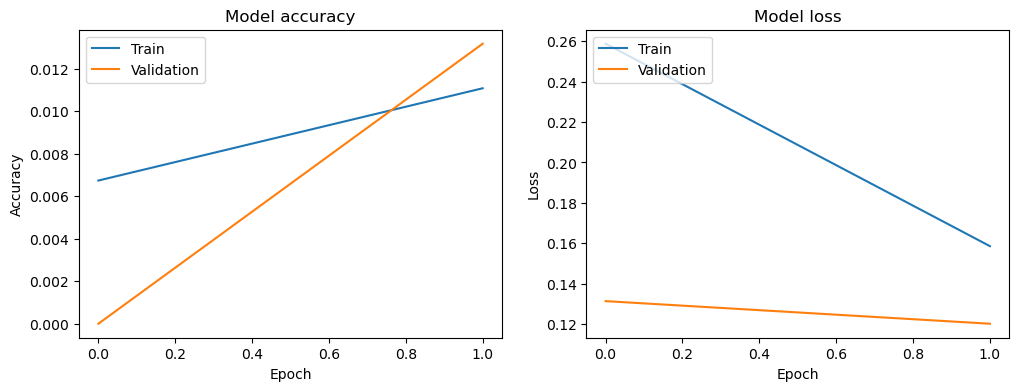

53/53 [==============================] - 5s 95ms/step


In [82]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Step 9: Evaluate the model
y_pred = model.predict(X_test)
# Convert predicted probabilities to binary (0 or 1) based on a threshold of 0.5
y_pred_binary = (y_pred > 0.5).astype(int)

Image shape: (128, 128, 3)
Labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]


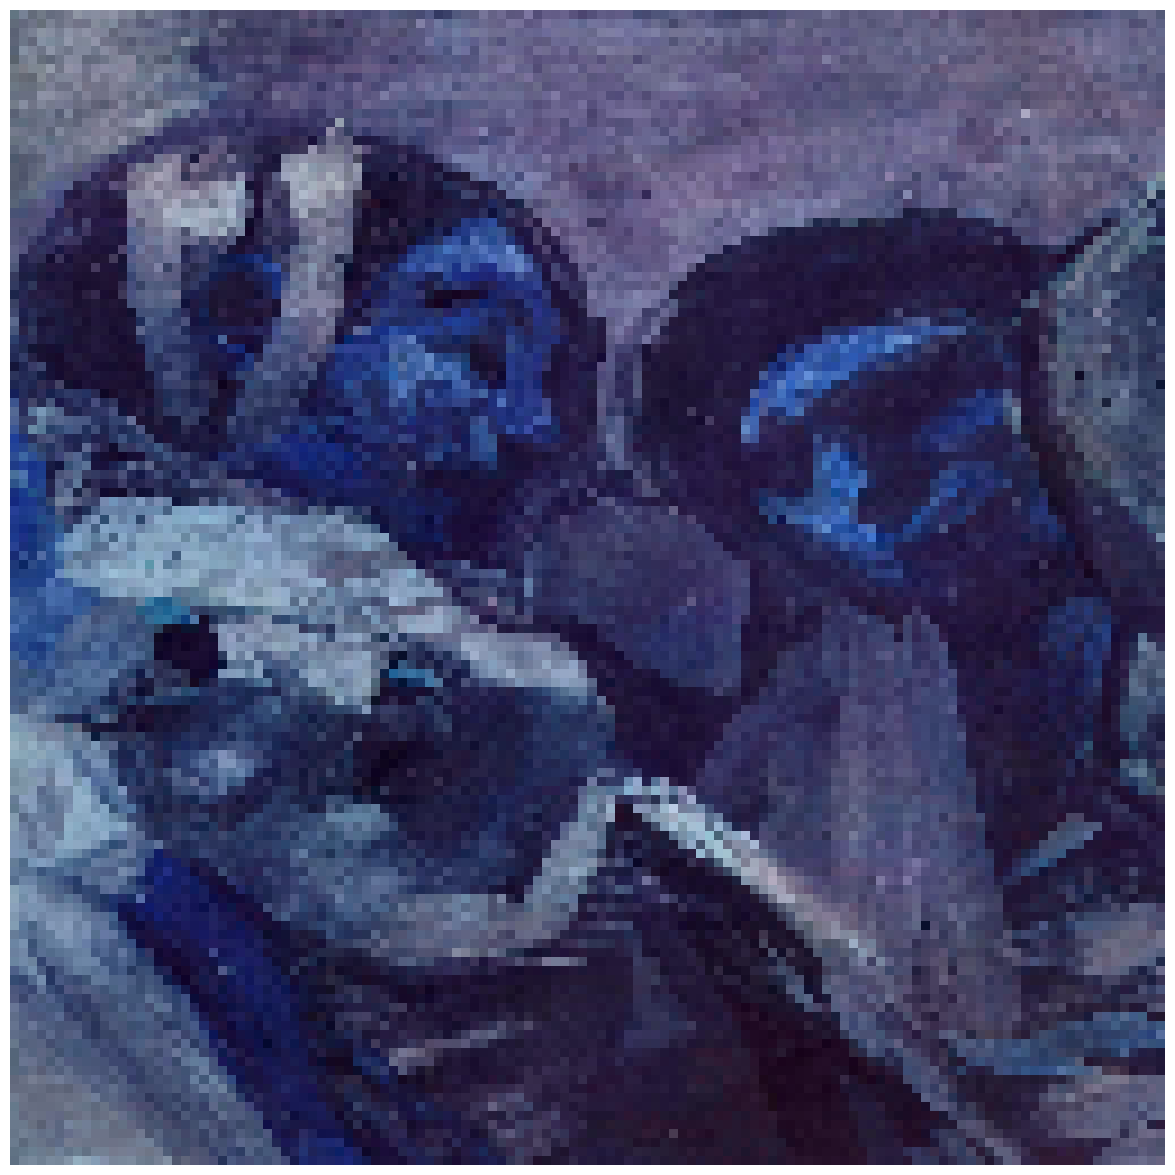

Image shape: (128, 128, 3)
Labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]


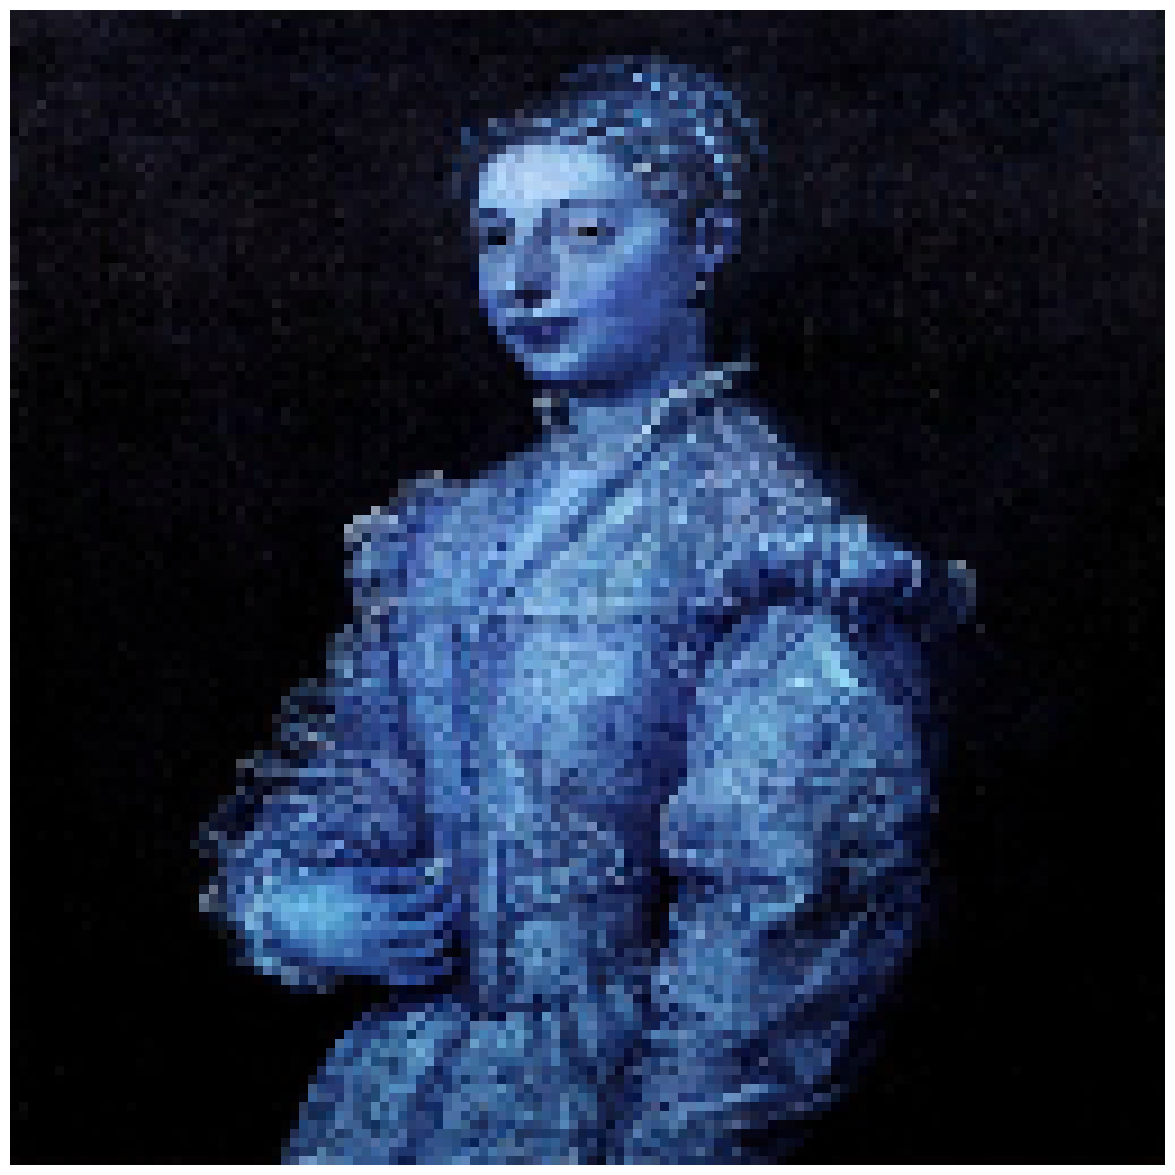

Image shape: (128, 128, 3)
Labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]


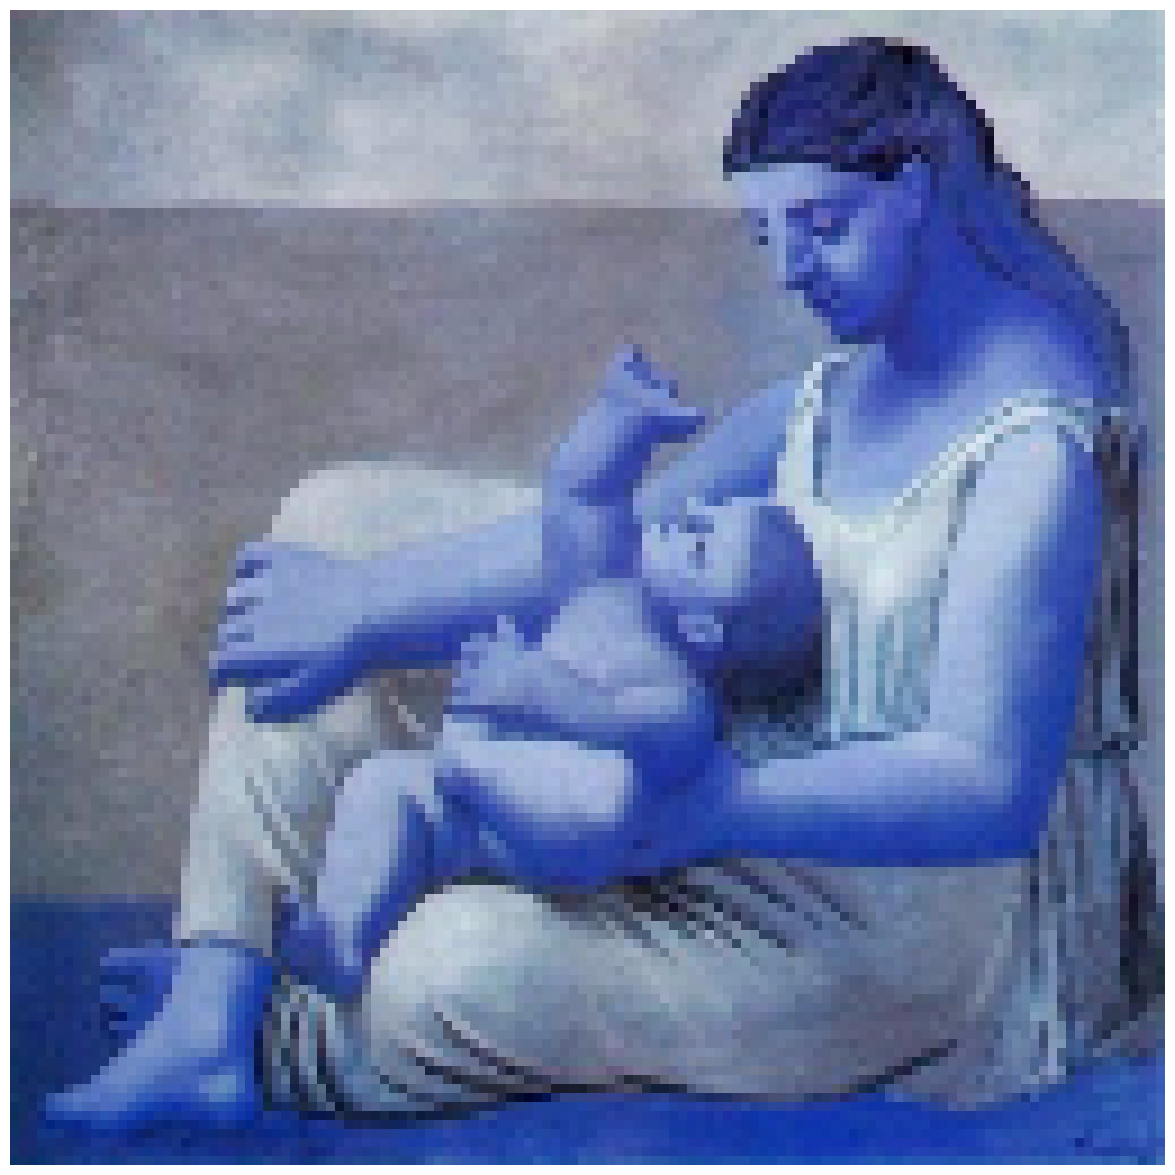

Image shape: (128, 128, 3)
Labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]


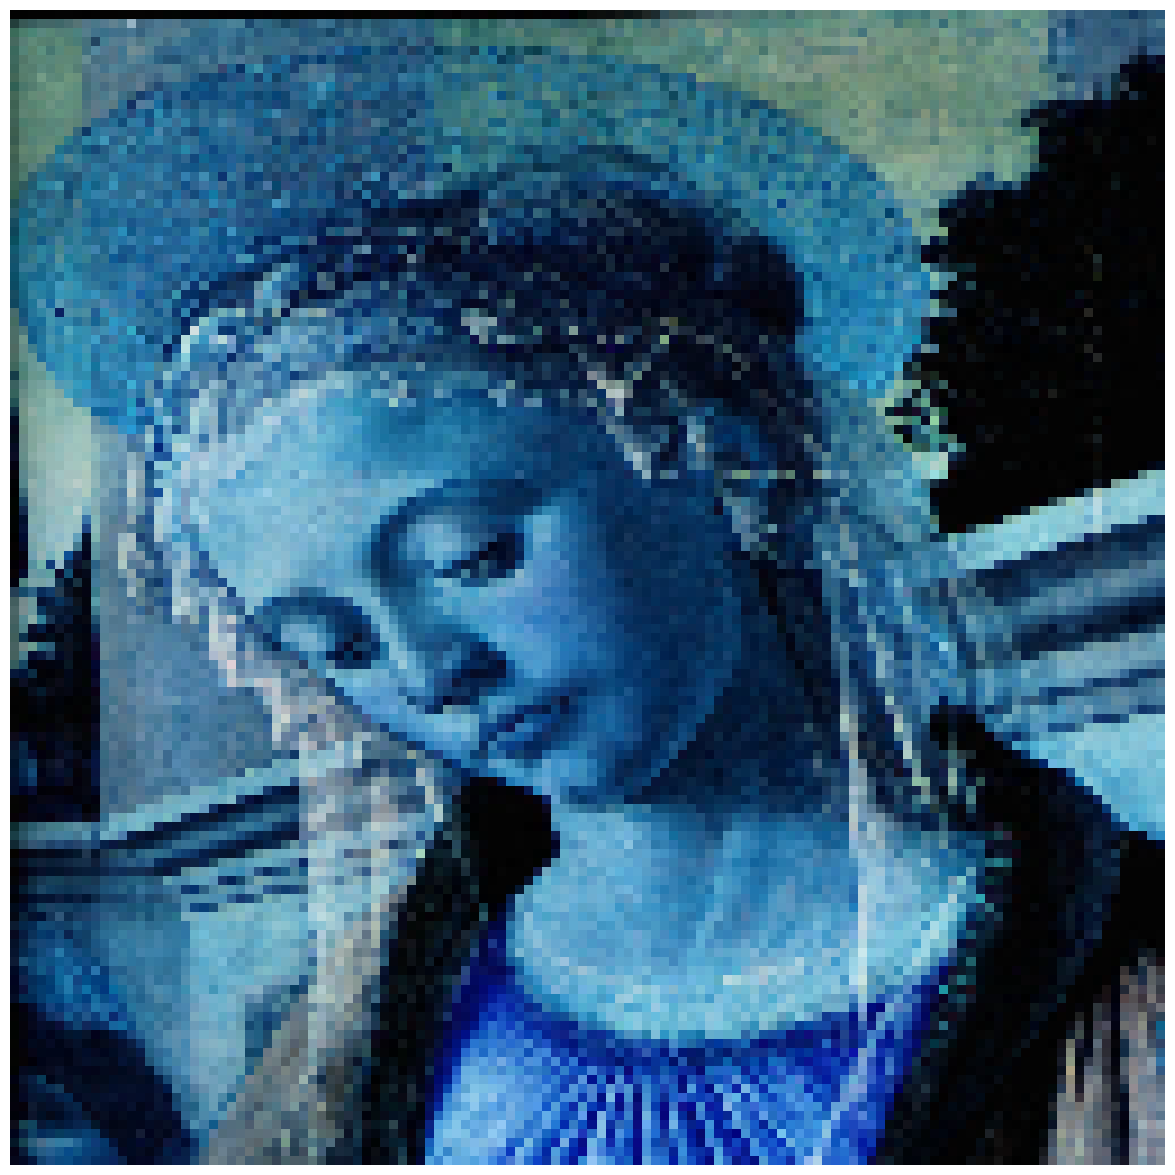

Image shape: (128, 128, 3)
Labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]


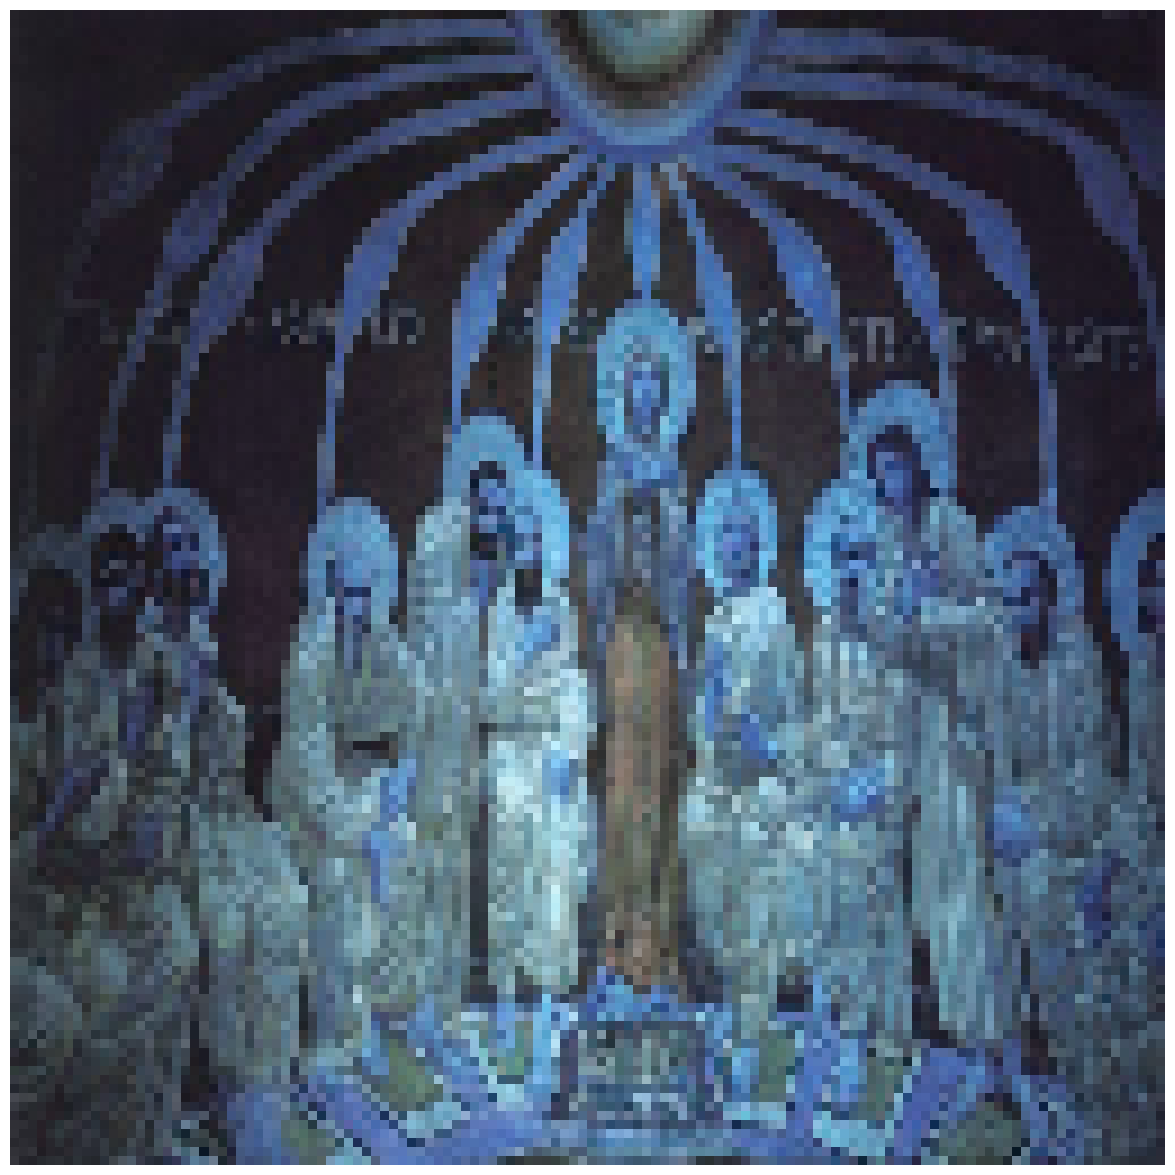

In [90]:
for i in range(5):
    print(f"Image shape: {X_train[i].shape}")
    print(f"Labels: {y_train[i]}")
    plt.imshow(X_train[i])
    plt.axis('off')
    plt.show()

In [99]:
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn.utils.class_weight import compute_class_weight

def compute_class_weights(y_encoded):
    class_weights = []
    for i in range(y_encoded.shape[1]):
        y_col = y_encoded[:, i]
        classes = np.unique(y_col)
        weight = compute_class_weight(class_weight='balanced', classes=classes, y=y_col)
        class_weights.append(weight[1])  # Assuming binary classes 0 and 1, use weight for class 1
    return np.array(class_weights)

class_weights = compute_class_weights(y_encoded)
print("Class weights shape:", class_weights.shape)


def weighted_binary_crossentropy(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    weights = K.constant(class_weights, dtype=tf.float32)
    bce = K.binary_crossentropy(y_true, y_pred)
    weighted_bce = bce * weights
    return K.mean(weighted_bce, axis=-1)



Class weights shape: (98,)


In [100]:
def normalize_name(name):
    name = unicodedata.normalize('NFKD', name).encode('ASCII', 'ignore').decode('ASCII')
    return name.replace(' ', '_')

# Function to load and preprocess the dataset
def load_and_preprocess_data(image_directory, csv_path):
    # Load artist information from CSV
    artist_df = pd.read_csv(csv_path)
    artist_info = {}
    for index, row in artist_df.iterrows():
        artist_key = normalize_name(row['name'])
        artist_info[artist_key] = {
            'name': row['name'],
            'genre': row['genre'],
            'nationality': row['nationality']
        }
    
    # Prepare the dataset
    features = []
    labels = []
    for filename in os.listdir(image_directory):
        if filename.endswith(".jpg"):
            artist_id_parts = '_'.join(filename.split('_')[:-1])  # Remove the last part (usually a number and extension)
            artist_key = normalize_name(artist_id_parts)
            
            if artist_key in artist_info:
                img_path = os.path.join(image_directory, filename)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, (128, 128))
                    features.append(img)
                    labels.append([artist_info[artist_key]['name'], artist_info[artist_key]['genre'], artist_info[artist_key]['nationality']])
            else:
                print(f"Missing artist info for ID: {artist_key}, Filename: {filename}")
    
    features = np.array(features).astype('float32') / 255.0
    labels = np.array(labels)
    return features, labels

# Load and preprocess the data
image_directory = './paintings'
csv_path = './artists.csv'
X, y = load_and_preprocess_data(image_directory, csv_path)

# Step 1: Encode the labels using MultiLabelBinarizer
mlb_name = MultiLabelBinarizer()
mlb_genre = MultiLabelBinarizer()
mlb_nationality = MultiLabelBinarizer()

y_name_encoded = mlb_name.fit_transform(y[:, 0].reshape(-1, 1))
y_genre_encoded = mlb_genre.fit_transform(y[:, 1].reshape(-1, 1))
y_nationality_encoded = mlb_nationality.fit_transform(y[:, 2].reshape(-1, 1))

# Print the number of unique labels in each category
print("Number of unique artist names:", len(mlb_name.classes_))
print("Number of unique genres:", len(mlb_genre.classes_))
print("Number of unique nationalities:", len(mlb_nationality.classes_))

# Calculate the total number of classes
num_classes = len(mlb_name.classes_) + len(mlb_genre.classes_) + len(mlb_nationality.classes_)
print("Total number of classes (num_classes):", num_classes)

# Concatenate the encoded labels
y_encoded = np.concatenate([y_name_encoded, y_genre_encoded, y_nationality_encoded], axis=1)

# Step 2: Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Step 3: Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)
datagen.fit(X_train)

# Step 4: Define the multi-label CNN model
def create_multilabel_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='sigmoid')
    ])
    return model

# Step 5: Calculate class weights for each label category
def compute_class_weights(y_encoded):
    class_weights = []
    for i in range(y_encoded.shape[1]):
        y_col = y_encoded[:, i]
        classes = np.unique(y_col)
        weight = compute_class_weight(class_weight='balanced', classes=classes, y=y_col)
        class_weights.append(weight[1])  # Assuming binary classes 0 and 1, use weight for class 1
    return np.array(class_weights)

class_weights = compute_class_weights(y_encoded)
print("Class weights shape:", class_weights.shape)

# Step 6: Define custom weighted binary cross-entropy loss
def weighted_binary_crossentropy(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    weights = K.constant(class_weights, dtype=tf.float32)
    bce = K.binary_crossentropy(y_true, y_pred)
    weighted_bce = bce * weights
    return K.mean(weighted_bce, axis=-1)

# Step 7: Create and compile the model
input_shape = (128, 128, 3)

model = create_multilabel_cnn_model(input_shape, num_classes)
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001), 
              loss=weighted_binary_crossentropy, 
              metrics=['accuracy'])

# Step 8: Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Step 9: Train the model
epochs = 30
batch_size = 32
history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                    validation_data=(X_test, y_test),
                    epochs=epochs,
                    callbacks=[early_stopping])


Number of unique artist names: 50
Number of unique genres: 31
Number of unique nationalities: 17
Total number of classes (num_classes): 98
Class weights shape: (98,)
Epoch 1/30
209/209 [==============================] - 100s 462ms/step - loss: 7.1534 - accuracy: 0.0048 - val_loss: 2.7481 - val_accuracy: 0.0000e+00
Epoch 2/30
209/209 [==============================] - 102s 486ms/step - loss: 3.5342 - accuracy: 0.0109 - val_loss: 2.4995 - val_accuracy: 0.0000e+00
Epoch 3/30
209/209 [==============================] - 90s 429ms/step - loss: 3.1108 - accuracy: 0.0105 - val_loss: 2.4312 - val_accuracy: 0.0000e+00
Epoch 4/30
209/209 [==============================] - 76s 362ms/step - loss: 2.9336 - accuracy: 0.0123 - val_loss: 2.4256 - val_accuracy: 0.0036
Epoch 5/30
209/209 [==============================] - 72s 344ms/step - loss: 2.7917 - accuracy: 0.0156 - val_loss: 2.3860 - val_accuracy: 0.0036
Epoch 6/30
209/209 [==============================] - 75s 358ms/step - loss: 2.7257 - accuracy:

KeyboardInterrupt: 

In [102]:
# Split the predictions for each label category
split_points = [len(mlb_name.classes_), len(mlb_name.classes_) + len(mlb_genre.classes_)]
y_test_name, y_test_genre, y_test_nationality = np.split(y_test, split_points, axis=1)
y_pred_name, y_pred_genre, y_pred_nationality = np.split(y_pred_binary, split_points, axis=1)

print(mlb_name.inverse_transform(y_test_name)[:5])
print(mlb_name.inverse_transform(y_pred_name)[:5])

[('Albrecht Dürer',), ('Francisco Goya',), ('Pierre-Auguste Renoir',), ('Gustave Courbet',), ('Francisco Goya',)]
[(), (), (), (), ()]


In [104]:
# from sklearn.metrics import precision_score, recall_score, f1_score

# # Function to calculate and print metrics for each label category
# def evaluate_performance(y_test, y_pred, classes):
#     accuracy = accuracy_score(y_test, y_pred)
#     precision = precision_score(y_test, y_pred, average='micro')
#     recall = recall_score(y_test, y_pred, average='micro')
#     f1 = f1_score(y_test, y_pred, average='micro')
    
#     print(f"Accuracy: {accuracy:.4f}")
#     print(f"Precision: {precision:.4f}")
#     print(f"Recall: {recall:.4f}")
#     print(f"F1 Score: {f1:.4f}")

#     # Print metrics for each class
#     for i, class_name in enumerate(classes):
#         class_precision = precision_score(y_test[:, i], y_pred[:, i])
#         class_recall = recall_score(y_test[:, i], y_pred[:, i])
#         class_f1 = f1_score(y_test[:, i], y_pred[:, i])
#         print(f"Class: {class_name} - Precision: {class_precision:.4f}, Recall: {class_recall:.4f}, F1 Score: {class_f1:.4f}")

# # Split the predictions for each label category
# split_points = [len(mlb_name.classes_), len(mlb_name.classes_) + len(mlb_genre.classes_)]
# y_test_name, y_test_genre, y_test_nationality = np.split(y_test, split_points, axis=1)
# y_pred_name, y_pred_genre, y_pred_nationality = np.split(y_pred_binary, split_points, axis=1)

# # Evaluate artist name predictions
# print("Artist Name Evaluation:")
# evaluate_performance(y_test_name, y_pred_name, mlb_name.classes_)

# # Evaluate genre predictions
# print("\nGenre Evaluation:")
# evaluate_performance(y_test_genre, y_pred_genre, mlb_genre.classes_)

# # Evaluate nationality predictions
# print("\nNationality Evaluation:")
# evaluate_performance(y_test_nationality, y_pred_nationality, mlb_nationality.classes_)
